# **Project 12 - Reinforcement Learning**

# Task description

We give a brief introduction about how to train an RL agent by policy gradient method. You will know details about the gym environment, implementation of policy gradient method by pytorch, and the training process. Your task is training an agent to achieve higher reward than the performance of the baseline we provide in this tutorial. You can select Policy Gradient, DQN, Actor-Critic and any other algorithm you know.

# Pre-operation

First, we need to install the necessary system kit and pypi kit.

Gym, a toolkit provided by openai, is used to develop and compare reinforcement learning algorithms.

The rest of the packages are needed to draw in the notebook.

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay tqdm

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

Next, set up the virtual display and introduce all necessary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

Finally, the gym of openai is introduced and an example is established [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [3]:
%%capture
import gym
env = gym.make('LunarLander-v2')

# Game Environment Description

In this project, we use “LunarLander-v2” in OpenAI gym as the environment of the simulator. You have to run your implement in this environment to test the performance, and you are encouraged to show performance on more environments in OpenAI gym or any other benchmarks.

This environment simulates the situation when the lunar landing craft lands on the lunar surface.

The goal of this mission is to land the moon landing craft 「safely」 on the flat ground between two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)


The so-called 「environment」 actually includes both agent and environment.
We use the `step()` function to make the agent act, and then the function will return the observation / state (the following two nouns mean the same) and reward given by the environment.

### Observation / State

First, we can see what the observation returned from the environment to the agent looks like:

In [4]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


`Box(8,)` It means that we will get the 8-dimensional vector as observation, including vertical and horizontal coordinates, velocity, angle, acceleration, etc. we won't elaborate on this part.

### Action

After the agent obtains observation and reward, the actions it can take are:

In [5]:
print(env.action_space)

Discrete(4)


`Discrete(4)` shows that agent can take four discrete actions:
- 0 represents no action
- 2 represents the downward injection of the main engine
- 1, 3 sprays left or right

Next, we try to make the agent interact with the environment.
Before any operation, it is recommended to call the `reset()` function to reset the entire environment.
This function also returns the initial state of the environment.

In [6]:
initial_state = env.reset()
print(initial_state)

[ 0.00370026  1.4125776   0.3747809   0.07366068 -0.0042809  -0.08489344
  0.          0.        ]


Then, we try to take a random action from the four action spaces of the agent

In [7]:
random_action = env.action_space.sample()
print(random_action)

2


Then use the `step()` function to let the agent sample an action according to the `random_action`.
This function will return four messages:
- observation / state
- reward
- complete or not
- other information

In [8]:
observation, reward, done, info = env.step(random_action)

The first information is the agent's `observation` or state of the environment after taking action.
The third message, `done`, is the Boolean value of `True` or `False`. When the lunar landing boat lands successfully or crashes unfortunately, it means that the round is over. At this time, the `step()` function will return `done = True`, and until then, `done` will remain `False`.

In [9]:
print(done)

False


### Reward

The reward given by "environment" is  calculated as follows:
- Boat crash - 100 points
- If the boat lands successfully between the yellow flags, 100 ~ 140 points will be obtained
- Jet the main engine (fire downward) every time - 0.3 points
- If the boat finally comes to a complete standstill, another 100 points will be given

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [10]:
print(reward)

-0.9940609178362252


### Random Agent

Finally, before entering the implementation, let's see whether such a random agent can successfully land on the moon:

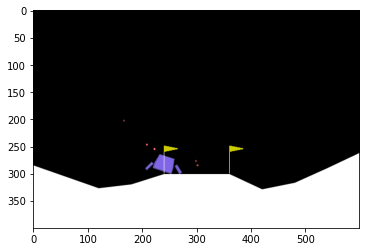

In [11]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Learn optimal policy to play the game by Policy Gradient algorithm  
Let $\pi_{\theta}$ denote a policy with parameters $\theta$, and $J(\pi_{\theta})$ denote the expected finite-horizon undiscounted return of the policy. The gradient of $J(\pi_{\theta})$ is

$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}{
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t)
    }$, where $\tau$ is a trajectory and $A^{\pi_{\theta}}$ is the advantage function for the current policy.

The policy gradient algorithm works by updating policy parameters via stochastic gradient ascent on policy performance:

$\theta_{k+1} = \theta_k + \alpha \nabla_{\theta} J(\pi_{\theta_k})$.

Policy gradient implementations typically compute advantage function estimates based on the infinite-horizon discounted return, despite otherwise using the finite-horizon undiscounted policy gradient formula.
![image-4.png](attachment:image-4.png)

## Implementation
Now let's build a simple policy network.
The input of our default model is 8-dim observation, and the output is one of the four discrete actions:

In [12]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

Next, build a simple agent and take action with the policy network above.

This agent can do the following things:

-` learn() `: update the policy network from the recorded log probabilities and rewards.

-` sample() `: after obtaining the observation from the environment, use the policy network to get the action that should be taken.

In addition to returning the sampled action, this function will also return the log probabilities of this sampling.

In [13]:
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Finally, establish a network and agent, and you can start training.

In [14]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Train the Agent

Now let's start training the agent.

By making the agent interact with the environment, we remember the log probabilities and reward corresponding to each group, and play back these "memories" to train the policy network after successful login or unfortunate crash.

In [15]:
agent.network.train()  # Before training, please make sure that the network is in training mode
EPISODE_PER_BATCH = 5  # Update the agent every 5 episodes collected
NUM_BATCH = 400        # 400 updates in total

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    # Collect training data
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward, total_step = 0, 0
        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # Set the same episode, and the reward of each action is total reward
                break
    # Record the training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the network
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/400 [00:00<?, ?it/s]

### Training results

During the training, we kept recording ` AVG_ total_ Reward `, this value represents: before updating the policy network each time, we let the agent play several rounds (episodes), and what is the average total rewards of these rounds.

Theoretically, if the agent has been making progress, the obtained ` AVG_ total_ Reward 'will also continue to rise up to 250.

If it is drawn, the results are as follows:

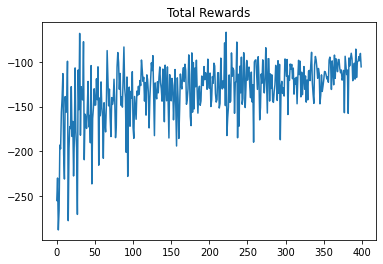

In [16]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

Also, ` avg_total_reward` represents the average final rewards of multiple rounds, and the final reward is the last reward obtained by the agent in a single round.

If you still remember the way the environment gives the lunar landing boat a reward, they will know that no matter whether the * * boat crashes, flies out of the picture, or stands still on the ground at the end of the * * round, it will receive additional rewards or punishment.

Therefore, final reward can be used to observe whether the "landing" of the agent is smooth.

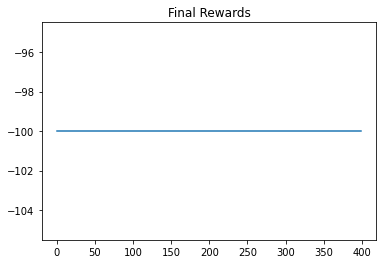

In [17]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing

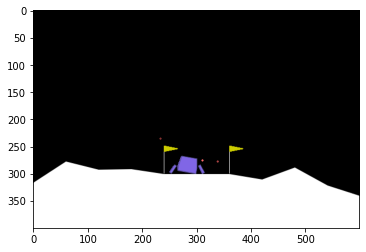

In [18]:
agent.network.eval()  # Switch the network to the evaluation mode before testing

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [19]:
print(total_reward)

-103.05325065131639
